In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
Max_date = session.query(func.max(Measurement.date)).all()
Max_date

[('2017-08-23',)]

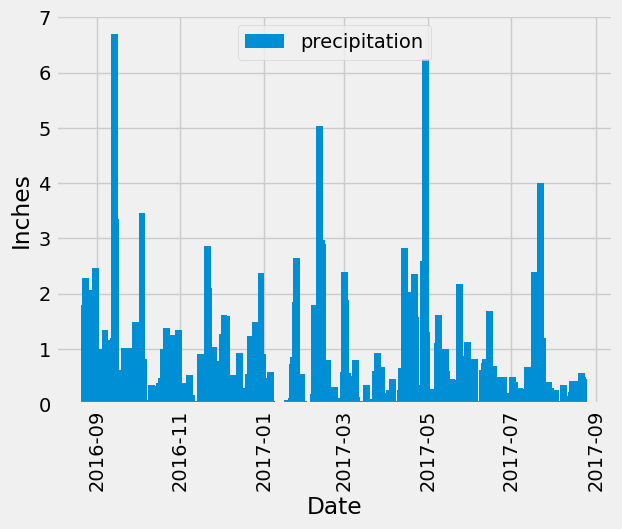

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.datetime(2017,8,23)

# Calculate the date one year from the last date in data set.
query_date = date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
date_prcp_df = pd.read_sql(f"SELECT Measurement.date, Measurement.prcp FROM Measurement where Measurement.date>='{query_date}'",conn)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prcp_df_clean = date_prcp_df.rename(columns={"prcp":"precipitation"}).dropna(how='any')

# Sort the dataframe by date
date_prcp_df_clean['date']= pd.to_datetime(date_prcp_df_clean['date'])
date_prcp_df_clean_sorted = date_prcp_df_clean.sort_values(by=['date'],ascending=True)
date_prcp_df_clean_sorted.dtypes

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = date_prcp_df_clean_sorted["date"]

plt.bar(x_axis,date_prcp_df_clean_sorted["precipitation"],alpha=1,align="center",label='precipitation',width=5)
plt.legend(loc='upper center')
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()



In [11]:
# or another solution:

# # Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# # Starting from the most recent data point in the database. 

# # Calculate the date one year from the last date in data set.
# prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# # Perform a query to retrieve the data and precipitation scores
# results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# # Save the query results as a Pandas DataFrame. Explicitly set the column names
# df = pd.DataFrame(results, columns=['date', 'precipitation'])

# # Sort the dataframe by date
# df = df.sort_values("date")

# # Use Pandas Plotting with Matplotlib to plot the data
# df.plot(x='date', y='precipitation', rot=90)
# plt.xlabel("Date")
# plt.ylabel("Inches")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df_clean_sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query (func.count(Station.name)).all()
stations
# or
# stations = session.query (Station.name).distinct().count()
# stations

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_groupby_sort = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_groupby_sort

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature_in_USC00519281 = session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').group_by(Measurement.station).all()
temperature_in_USC00519281

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

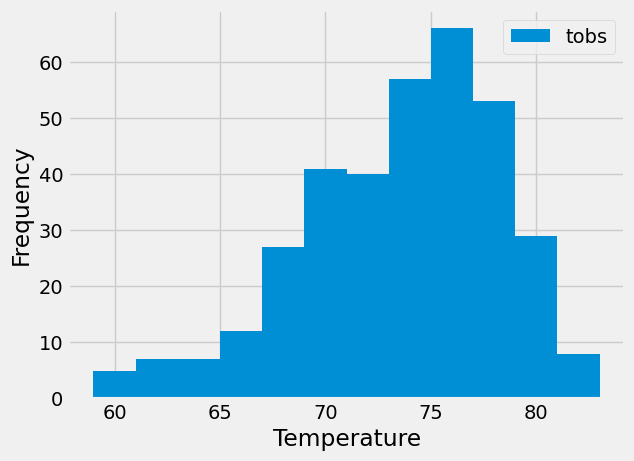

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_in_USC00519281 = session.query(Measurement.station,Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date>=query_date).\
    group_by(Measurement.date).\
all()
temperature_in_USC00519281_df = pd.DataFrame(temperature_in_USC00519281)

temperature_in_USC00519281_df.plot.hist(bins=12)
plt.xlabel("Temperature")



# Close Session

In [17]:
# Close Session
session.close()